In [1]:
# Modules
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import inspect
import warnings

from sklearn import ensemble, metrics, model_selection, preprocessing, tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from tensorflow.keras import callbacks, initializers, layers, losses, models, optimizers
from sklearn import datasets, metrics, model_selection, preprocessing
from tensorflow import keras
from tensorflow.keras import losses, optimizers, metrics
from sklearn.metrics import roc_curve
from sklearn import linear_model, metrics, model_selection, preprocessing
from tensorflow.keras import datasets, layers, losses, models, optimizers, regularizers
from matplotlib import pyplot


# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
def display_roc(fp_rates:np.ndarray, tp_rates:np.ndarray, thresholds:np.ndarray, best_index:int=None) -> None:
    '''Displays ROC curve and AUC'''
    auc     = metrics.auc(fp_rates, tp_rates)
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(fp_rates, tp_rates, color='blue', label=f'AUC: {auc:0.4f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='dashed')
    if best_index is not None:
        ax.scatter(fp_rates[best_index], tp_rates[best_index], marker='o', c='lightgreen', s=7.5**2, edgecolor='black', zorder=2, label=f'Threshold: {thresholds[best_index]:0.4f}')
    ax.set_title('Receiver operating characteristic')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc='lower right', frameon=False)
    pyplot.tight_layout()
    pyplot.show()

def display_history(history:dict, stat:str='loss', validation:bool=False) -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[stat], label='Training sample')
    if validation:
        ax.plot(history[f'val_{stat}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(stat.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()
    
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

# Reading Data

In [3]:
# Import the data
df_selected = pd.read_csv('Data_selection.csv')
df_no_selection = pd.read_csv('Data_no_selection.csv')

In [4]:
df = df_selected

# Randomly split the data set into training and testing and deal with the imbalanced dependent variable using SMOTE
y = df['TARGET']
X = df.drop('TARGET', axis=1)
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y.values.astype(float), train_size = 0.75, shuffle = True, random_state = 480)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size = 0.75, shuffle = True, random_state = 480)

undersampler = RandomUnderSampler(random_state=480)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)


# Model Creation

In [5]:
# Models structure
def build_model(input_shape:int):
  initializer = initializers.HeNormal(seed=0)
  inputs  = layers.Input(shape=(input_shape,), name='input_layer')
  hidden  = layers.Dense(units=32, activation='relu',    kernel_initializer=initializer, name='hidden_layer1')(inputs)
  hidden  = layers.Dense(units=32, activation='relu',    kernel_initializer=initializer, name='hidden_layer2')(hidden)
  outputs = layers.Dense(units=1,  activation='sigmoid', kernel_initializer=initializer, name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='simple_model')
  return model

# Builds model
model = build_model(input_shape=60)
model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 60)]              0         
                                                                 
 hidden_layer1 (Dense)       (None, 32)                1952      
                                                                 
 hidden_layer2 (Dense)       (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 3,041
Trainable params: 3,041
Non-trainable params: 0
_________________________________________________________________


# Dropout + L2 Reg

In [52]:
# Model structure
def build_model(input_shape:int):
  initializer = initializers.HeNormal(seed=0)
  inputs  = layers.Input(shape=(input_shape,), name='input_layer')
  hidden  = layers.Dense(units=32, activation='relu', kernel_initializer=initializer, name='hidden_layer1')(inputs)
  hidden  = layers.Dropout(rate=0.1, name='droupout_layer1')(hidden)
  hidden  = layers.Dense(units=32, activation='relu', kernel_initializer=initializer, name='hidden_layer2')(hidden)
  hidden  = layers.Dropout(rate=0.1, name='droupout_layer2')(hidden)
  outputs = layers.Dense(units=1,  activation='sigmoid', name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='dropout_model')
  return model

model = build_model(input_shape=60)
model.summary()

Model: "dropout_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 60)]              0         
                                                                 
 hidden_layer1 (Dense)       (None, 32)                1952      
                                                                 
 droupout_layer1 (Dropout)   (None, 32)                0         
                                                                 
 hidden_layer2 (Dense)       (None, 32)                1056      
                                                                 
 droupout_layer2 (Dropout)   (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 3,041
Trainable params: 3,041
Non-train

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC

#model = build_model(input_shape=60)
for layer in ['hidden_layer1', 'hidden_layer2']:
    model.get_layer(layer).kernel_regularizer = regularizers.l2() 
    model.get_layer(layer).bias_regularizer   = regularizers.l2() 
    
 
    
#model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[BinaryAccuracy(),
        Precision(),
        Recall(),
        AUC()])

# Compile Model

In [55]:
train_params = dict(epochs=100, verbose=1)
training     = model.fit(X_train_resampled, y_train_resampled, **train_params)

Epoch 1/100
1163/1163 [==============================] - 3s 2ms/step - loss: 0.6473 - binary_accuracy: 0.6270 - precision_5: 0.6280 - recall_5: 0.6229 - auc_5: 0.6730
Epoch 2/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.6265 - binary_accuracy: 0.6525 - precision_5: 0.6528 - recall_5: 0.6515 - auc_5: 0.7063
Epoch 3/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.6232 - binary_accuracy: 0.6565 - precision_5: 0.6554 - recall_5: 0.6601 - auc_5: 0.7107
Epoch 4/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.6203 - binary_accuracy: 0.6585 - precision_5: 0.6567 - recall_5: 0.6642 - auc_5: 0.7146
Epoch 5/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.6186 - binary_accuracy: 0.6593 - precision_5: 0.6562 - recall_5: 0.6692 - auc_5: 0.7167
Epoch 6/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.6162 - binary_accuracy: 0.6619 - precision_5: 0.6602 - recall_5: 0.6674 - auc_5: 0.720

1163/1163 [==============================] - 2s 2ms/step - loss: 0.5895 - binary_accuracy: 0.6827 - precision_5: 0.6821 - recall_5: 0.6845 - auc_5: 0.7513
Epoch 50/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5880 - binary_accuracy: 0.6867 - precision_5: 0.6860 - recall_5: 0.6884 - auc_5: 0.7532
Epoch 51/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5884 - binary_accuracy: 0.6834 - precision_5: 0.6848 - recall_5: 0.6798 - auc_5: 0.7520
Epoch 52/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5872 - binary_accuracy: 0.6857 - precision_5: 0.6850 - recall_5: 0.6874 - auc_5: 0.7538
Epoch 53/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5888 - binary_accuracy: 0.6837 - precision_5: 0.6826 - recall_5: 0.6865 - auc_5: 0.7522
Epoch 54/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5884 - binary_accuracy: 0.6846 - precision_5: 0.6840 - recall_5: 0.6861 - auc_5: 0.7524
Epoch

1163/1163 [==============================] - 2s 2ms/step - loss: 0.5783 - binary_accuracy: 0.6920 - precision_5: 0.6920 - recall_5: 0.6920 - auc_5: 0.7632
Epoch 98/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5780 - binary_accuracy: 0.6937 - precision_5: 0.6943 - recall_5: 0.6921 - auc_5: 0.7639
Epoch 99/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5776 - binary_accuracy: 0.6929 - precision_5: 0.6926 - recall_5: 0.6935 - auc_5: 0.7638
Epoch 100/100
1163/1163 [==============================] - 2s 2ms/step - loss: 0.5786 - binary_accuracy: 0.6916 - precision_5: 0.6918 - recall_5: 0.6912 - auc_5: 0.7625


In [56]:
a =  model.evaluate(X_train_resampled, y_train_resampled)
a = [round(x, 4) for x in a]
a

1163/1163 [==============================] - 2s 1ms/step - loss: 0.5609 - binary_accuracy: 0.7059 - precision_5: 0.7079 - recall_5: 0.7010 - auc_5: 0.7831


[0.5609, 0.7059, 0.7079, 0.701, 0.7831]

In [57]:
b =  model.evaluate(X_test_resampled, y_test_resampled)
b = [round(x, 4) for x in b]
b

389/389 [==============================] - 1s 1ms/step - loss: 0.6400 - binary_accuracy: 0.6509 - precision_5: 0.6545 - recall_5: 0.6392 - auc_5: 0.6994


[0.64, 0.6509, 0.6545, 0.6392, 0.6994]

In [58]:
data = {'Metric': ['Binary Accuracy', 'Precision', 'Recall','ROC AUC'],
        'Training': [a[1], a[2], a[3], a[4]],
        'Test': [b[1], b[2], b[3], b[4]]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,Binary Accuracy,0.7059,0.6509
1,Precision,0.7079,0.6545
2,Recall,0.7010,0.6392
3,ROC AUC,0.7831,0.6994


389/389 [==============================] - 0s 1ms/step


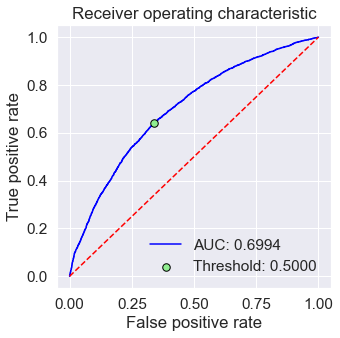

In [59]:
# ROC curve
yh_test = np.squeeze(model.predict(X_test_resampled))
fp_rates, tp_rates, thresholds = metrics.roc_curve(y_test_resampled, yh_test)
youden = np.argmax(tp_rates - fp_rates)
display_roc(fp_rates, tp_rates, thresholds, youden)

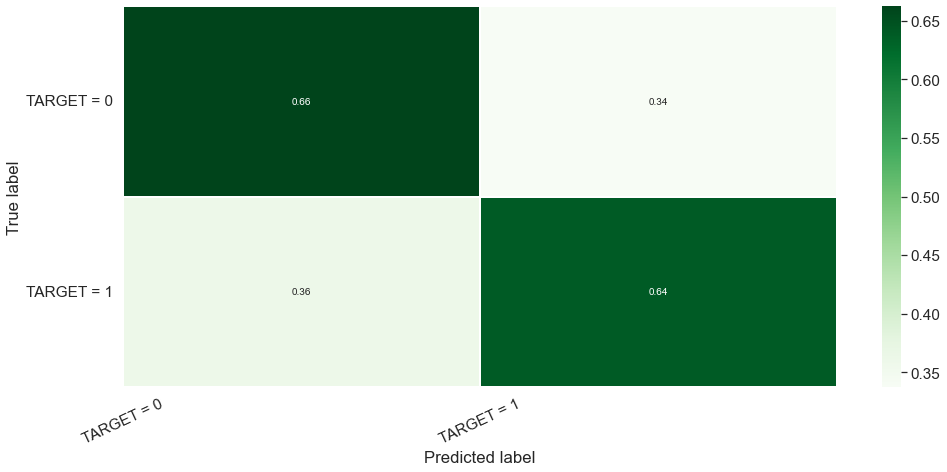

In [60]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test_resampled, yh_test > thresholds[youden])
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
pyplot.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=pyplot.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['TARGET = 0', 'TARGET = 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
pyplot.xticks(tick_marks, class_names, rotation=25)
pyplot.yticks(tick_marks2, class_names, rotation=0)
pyplot.xlabel('Predicted label')
pyplot.ylabel('True label')
#pyplot.title('Confusion Matrix for Random Forest Model')
pyplot.show()

# Importance Score

In [68]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def calculate_feature_importance_from_history(history, X, y, metric=accuracy_score, threshold=0.5, max_features=None, max_iterations=None):
    if max_features is None:
        max_features = X.shape[1]
    if max_iterations is None:
        max_iterations = 10

    baseline_score = metric(y, (history.model.predict(X) >= threshold).astype(int))
    feature_importance = np.zeros(X.shape[1])

    for feature in range(max_features):
        # Make a copy of the input data
        X_permuted = X.copy()

        scores = []
        for _ in range(max_iterations):
            # Randomly permute the values of the current feature
            X_permuted[:, feature] = shuffle(X_permuted[:, feature])

            # Calculate the score with permuted feature
            permuted_score = metric(y, (history.model.predict(X_permuted) >= threshold).astype(int))
            scores.append(permuted_score)

        # Calculate the feature importance as the decrease in score
        feature_importance[feature] = baseline_score - np.mean(scores)

    # Normalize feature importance to sum up to 1
    feature_importance /= np.sum(feature_importance)

    return feature_importance

# Assuming you have a history object from a trained model called 'history', input data 'X', and corresponding labels 'y'
importance = calculate_feature_importance_from_history(training, X_train_resampled.to_numpy(), y_train_resampled, max_features=10, max_iterations=5)
print(importance)


1163/1163 [==============================] - 1s 1ms/step


InvalidIndexError: (slice(None, None, None), 0)

In [71]:
importance_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
importance_df

,Feature,Importance
6,FLAG_CONT_MOBILE,0.458222
7,REG_REGION_NOT_WORK_REGION,0.153297
9,application_train_AMT_CREDIT_SUM,0.115337
8,"AMT_CREDIT_SUM_LIMIT_(20.16, 23563.475]",0.109762
4,application_train_flag_AMT_DRAWINGS_CURRENT,0.069458
3,"DAYS_EMPLOYED_(-144.0, 365243.0]",0.046625
5,REGION_RATING_CLIENT_1,0.029154
0,ORGANIZATION_TYPE_Business Entity Type 2,0.014417
1,DAYS_REGISTRATION,0.003551
2,application_train_flag_OBS_30_CNT_SOCIAL_CIRCLE,0.000178


# Partial Indep Plot

9610/9610 [==============================] - 11s 1ms/step


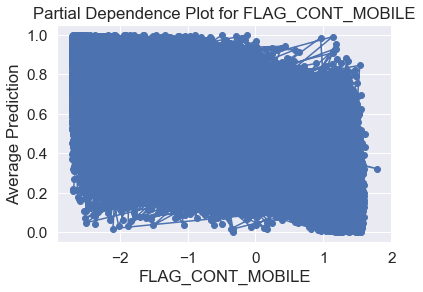

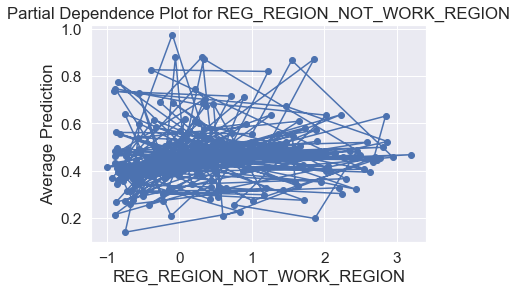

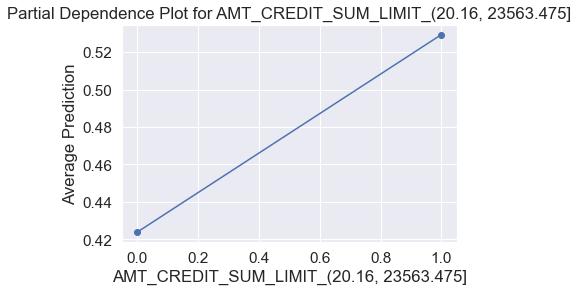

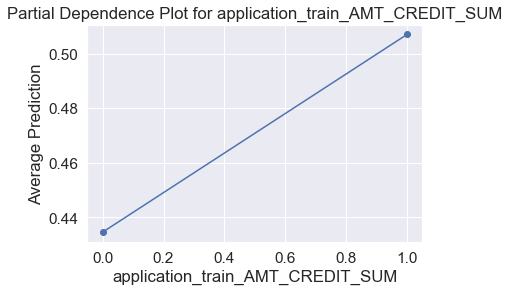

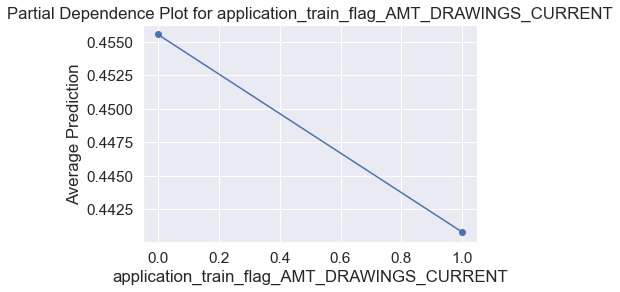

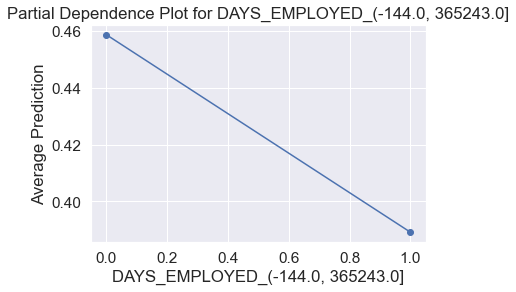

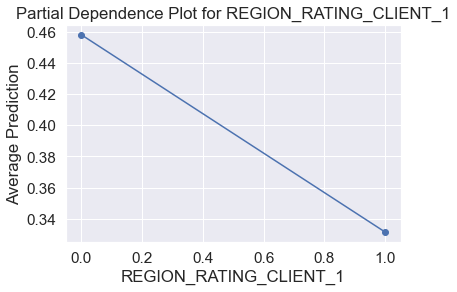

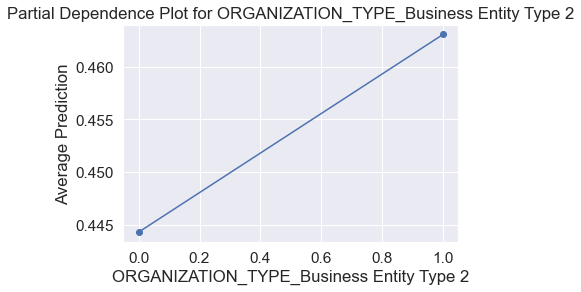

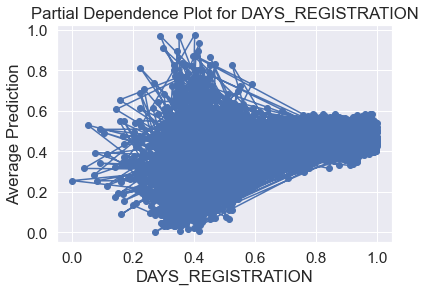

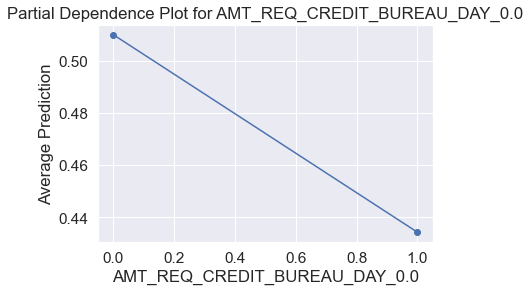

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from pdpbox import pdp

top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Select the top 10 features with highest importance scores
top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Create a copy of the input data for permutation
X_permuted = X.copy()

# Create a list to store the partial dependence results
pdp_plots = []

for feature in top_features:
    # Randomly permute the values of the current feature
    X_permuted[feature] = shuffle(X_permuted[feature])
    
    # Make predictions on permuted data
    predictions = model.predict(X_permuted)
    
    # Calculate the average prediction for each unique value of the feature
    feature_values = X_permuted[feature].unique()
    avg_predictions = []
    for value in feature_values:
        indices = X_permuted[feature] == value
        avg_prediction = np.mean(predictions[indices])
        avg_predictions.append(avg_prediction)
    
    # Store the partial dependence results
    pdp_plots.append((feature, feature_values, avg_predictions))

# Plot the partial dependence plots
for feature, feature_values, avg_predictions in pdp_plots:
    plt.figure()
    plt.plot(feature_values, avg_predictions, marker='o')
    plt.xlabel(feature)
    plt.ylabel('Average Prediction')
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from pdpbox import pdp

top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Select the top 10 features with highest importance scores
top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Create a copy of the input data for permutation
X_permuted = X.copy()

# Create a list to store the partial dependence results
pdp_plots = []

for feature in top_features:
    # Randomly permute the values of the current feature
    X_permuted[feature] = shuffle(X_permuted[feature])
    
    # Make predictions on permuted data
    predictions = model.predict(X_permuted)
    
    # Calculate the average prediction for each unique value of the feature
    feature_values = X_permuted[feature].unique()
    avg_predictions = []
    for value in feature_values:
        indices = X_permuted[feature] == value
        avg_prediction = np.mean(predictions[indices])
        avg_predictions.append(avg_prediction)
    
    # Store the partial dependence results
    pdp_plots.append((feature, feature_values, avg_predictions))

# Plot the partial dependence plots
for feature, feature_values, avg_predictions in pdp_plots:
    plt.figure()
    plt.plot(feature_values, avg_predictions, marker='o')
    plt.xlabel(feature)
    plt.ylabel('Average Prediction')
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.show()

9610/9610 [==============================] - 11s 1ms/step


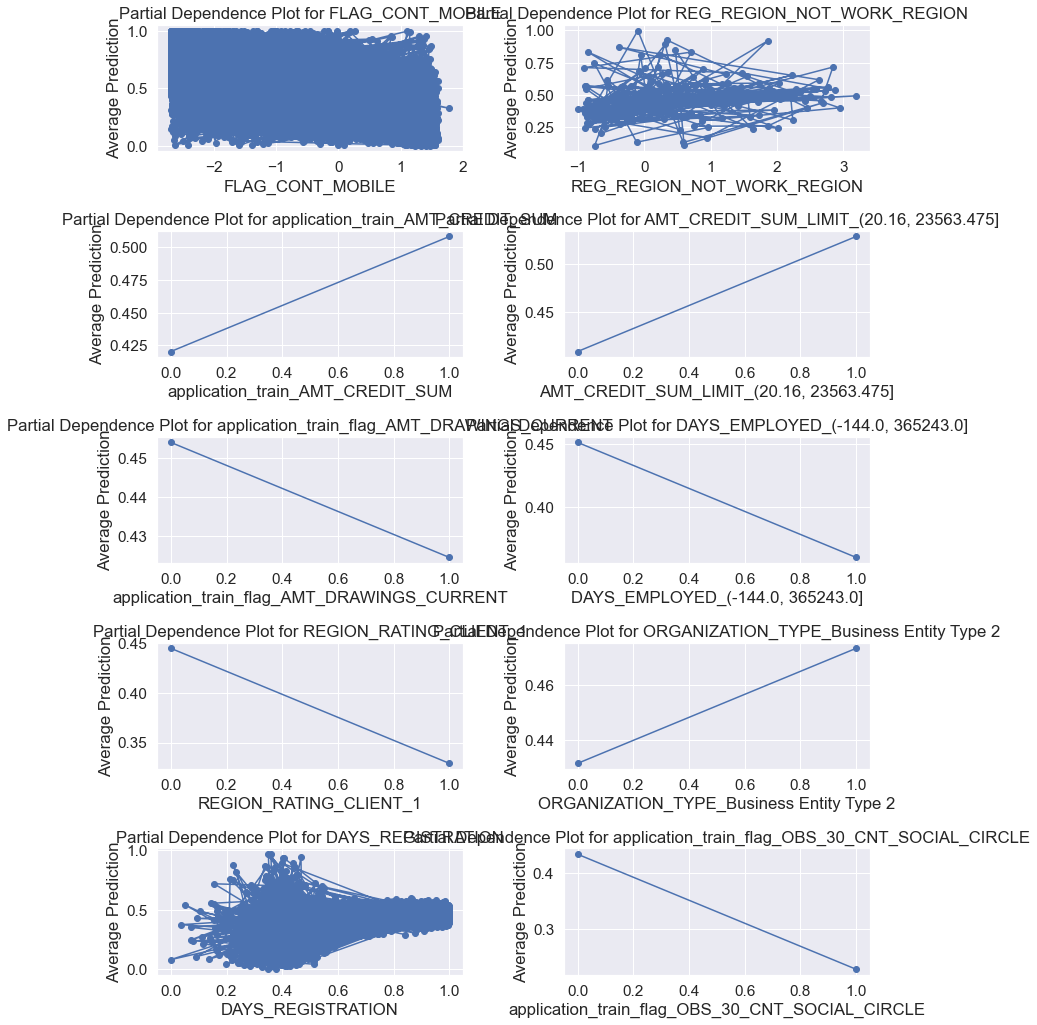

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from pdpbox import pdp

top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Select the top 10 features with highest importance scores
top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Create a copy of the input data for permutation
X_permuted = X.copy()

# Create a list to store the partial dependence results
pdp_plots = []

fig, axes = plt.subplots(5, 2, figsize=(12, 15))
fig.tight_layout(pad=3.0)

for i, feature in enumerate(top_features):
    # Randomly permute the values of the current feature
    X_permuted[feature] = shuffle(X_permuted[feature])

    # Make predictions on permuted data
    predictions = model.predict(X_permuted)

    # Calculate the average prediction for each unique value of the feature
    feature_values = X_permuted[feature].unique()
    avg_predictions = []
    for value in feature_values:
        indices = X_permuted[feature] == value
        avg_prediction = np.mean(predictions[indices])
        avg_predictions.append(avg_prediction)

    # Store the partial dependence results
    pdp_plots.append((feature, feature_values, avg_predictions))

    # Plot the partial dependence plot in the corresponding subplot
    ax = axes[i // 2, i % 2]
    ax.plot(feature_values, avg_predictions, marker='o')
    ax.set_xlabel(feature)
    ax.set_ylabel('Average Prediction')
    ax.set_title(f'Partial Dependence Plot for {feature}')

plt.show()


9610/9610 [==============================] - 10s 1ms/step


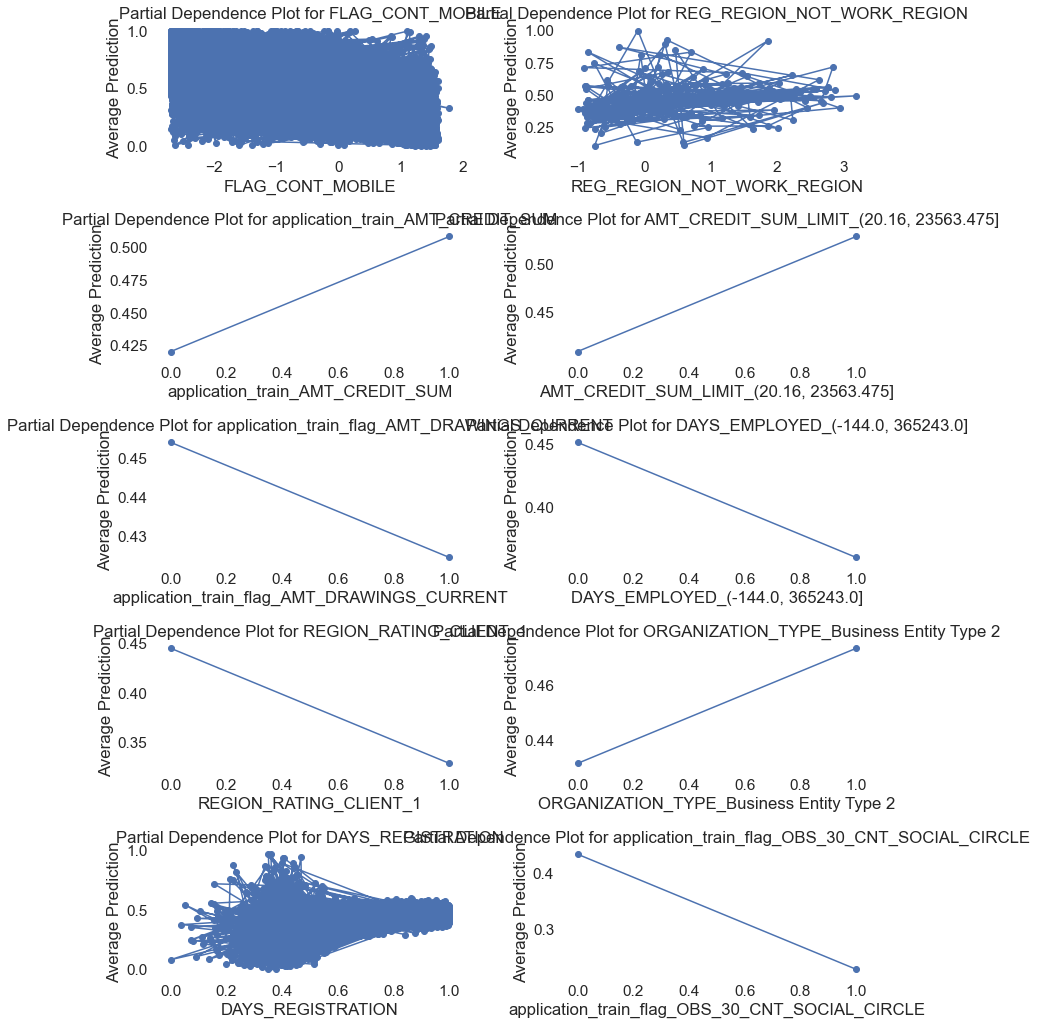

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from pdpbox import pdp

top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Select the top 10 features with highest importance scores
top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Create a copy of the input data for permutation
X_permuted = X.copy()

# Create a list to store the partial dependence results
pdp_plots = []

fig, axes = plt.subplots(5, 2, figsize=(12, 15))
fig.tight_layout(pad=3.0)

for i, feature in enumerate(top_features):
    # Randomly permute the values of the current feature
    X_permuted[feature] = shuffle(X_permuted[feature])

    # Make predictions on permuted data
    predictions = model.predict(X_permuted)

    # Calculate the average prediction for each unique value of the feature
    feature_values = X_permuted[feature].unique()
    avg_predictions = []
    for value in feature_values:
        indices = X_permuted[feature] == value
        avg_prediction = np.mean(predictions[indices])
        avg_predictions.append(avg_prediction)

    # Store the partial dependence results
    pdp_plots.append((feature, feature_values, avg_predictions))

    # Plot the partial dependence plot in the corresponding subplot
    ax = axes[i // 2, i % 2]
    ax.plot(feature_values, avg_predictions, marker='o')
    ax.set_xlabel(feature)
    ax.set_ylabel('Average Prediction')
    ax.set_title(f'Partial Dependence Plot for {feature}')
    
    # Set the background color to white
    ax.set_facecolor('white')

plt.show()


9610/9610 [==============================] - 10s 1ms/step


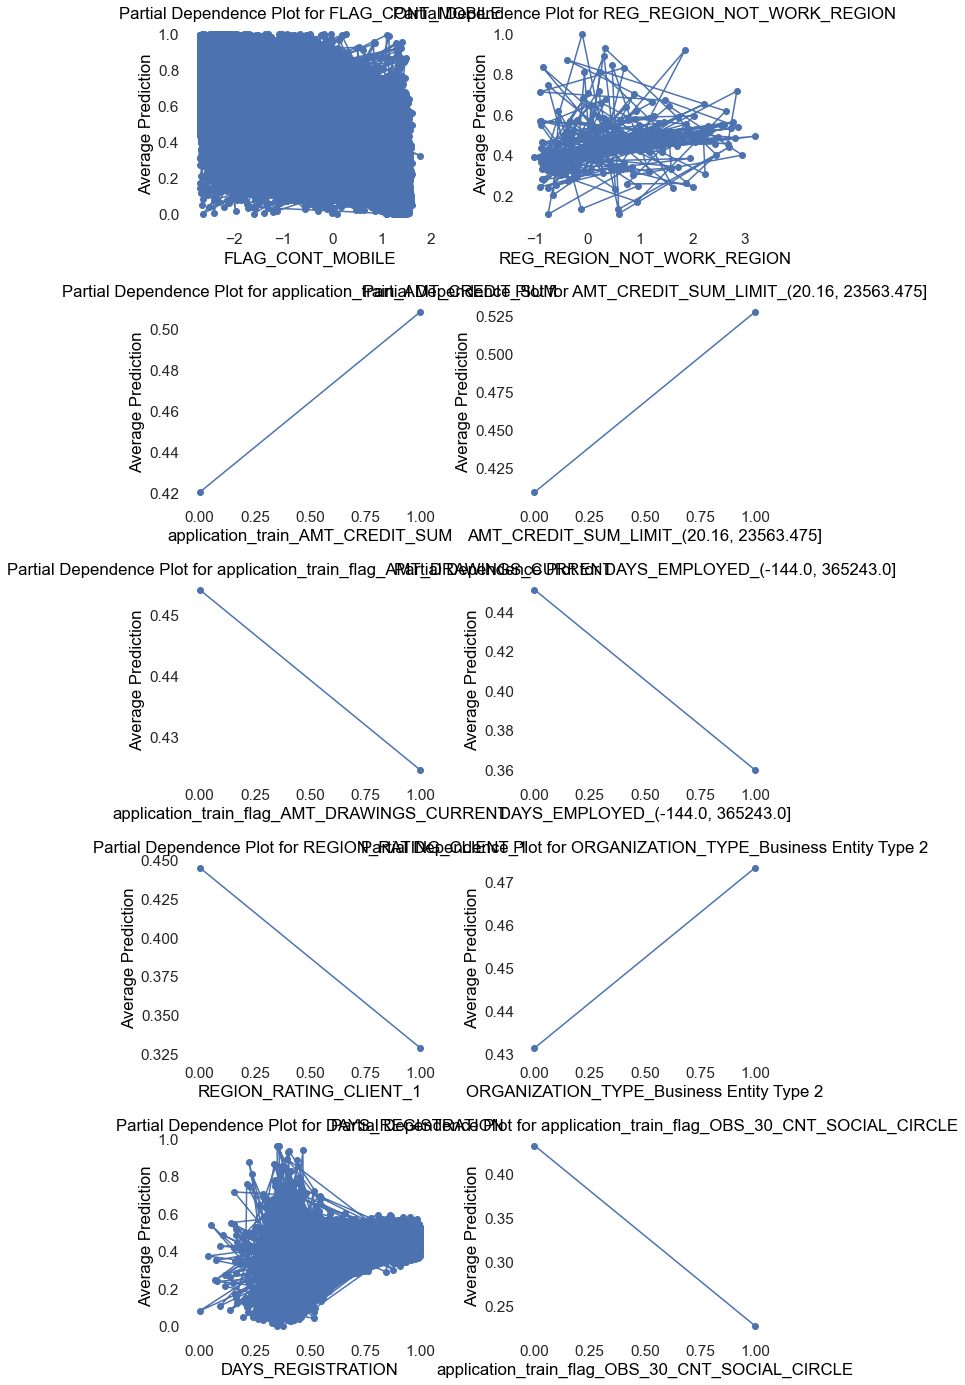

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from pdpbox import pdp

top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Select the top 10 features with highest importance scores
top_features_indices = np.argsort(importance)[-10:][::-1]
top_features = X_train_resampled.columns[top_features_indices]

# Create a copy of the input data for permutation
X_permuted = X.copy()

# Create a list to store the partial dependence results
pdp_plots = []

# Set the border color
border_color = 'black'

for feature in top_features:
    # Randomly permute the values of the current feature
    X_permuted[feature] = shuffle(X_permuted[feature])
    
    # Make predictions on permuted data
    predictions = model.predict(X_permuted)
    
    # Calculate the average prediction for each unique value of the feature
    feature_values = X_permuted[feature].unique()
    avg_predictions = []
    for value in feature_values:
        indices = X_permuted[feature] == value
        avg_prediction = np.mean(predictions[indices])
        avg_predictions.append(avg_prediction)
    
    # Store the partial dependence results
    pdp_plots.append((feature, feature_values, avg_predictions))

# Set the background color and border color for all plots
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = border_color

# Plot the partial dependence plots
num_plots = len(pdp_plots)
num_rows = num_plots // 2 + num_plots % 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
fig.tight_layout(pad=3.0)

for i, (feature, feature_values, avg_predictions) in enumerate(pdp_plots):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.plot(feature_values, avg_predictions, marker='o')
    ax.set_xlabel(feature)
    ax.set_ylabel('Average Prediction')
    ax.set_title(f'Partial Dependence Plot for {feature}')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.tick_params(axis='both', color=border_color)
    ax.yaxis.label.set_color(border_color)
    ax.xaxis.label.set_color(border_color)
    ax.title.set_color(border_color)
    
plt.show()
